# Predicting House Prices

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import rfpimp

Load the data

In [2]:
houses = pd.read_csv('kc_house_data.csv')

First let's drop a couple columns that seem redundant, and convert the date column into a datetime object. We'll also add another column which is the date represented as a number (so we can use the date as a continuous variable if we want).

In [3]:
houses.drop(['sqft_living15', 'sqft_lot15', 'id', 'zipcode'], axis=1, inplace=True)
houses['date_sold'] = pd.to_datetime(houses['date'])
houses.drop('date', axis=1, inplace=True)
houses['date_num'] = pd.to_numeric(houses.date_sold)

In [4]:
houses.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,date_sold,date_num
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,2014-10-13,1413158400000000000
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,47.7210,-122.319,2014-12-09,1418083200000000000
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2015-02-25,1424822400000000000
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,47.5208,-122.393,2014-12-09,1418083200000000000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,2015-02-18,1424217600000000000


Examining the data, we can also see that this dataset covers approximately a year’s worth of house sales, starting May 2, 2014 and ending May 27, 2015.

In [5]:
houses.date_sold.describe()

count                   21613
unique                    372
top       2014-06-23 00:00:00
freq                      142
first     2014-05-02 00:00:00
last      2015-05-27 00:00:00
Name: date_sold, dtype: object

In [6]:
houses.describe().astype(object)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,date_num
count,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613
mean,540182,3.37084,2.11476,2079.9,15107,1.49431,0.00754176,0.234303,3.40943,7.65687,1788.39,291.509,1971.01,84.4023,47.5601,-122.214,1.41456e+18
std,367362,0.930062,0.770163,918.441,41420.5,0.539989,0.0865172,0.766318,0.650743,1.17546,828.091,442.575,29.3734,401.679,0.138564,0.140828,9.76735e+15
min,75000,0,0,290,520,1,0,0,1,1,290,0,1900,0,47.1559,-122.519,1.39899e+18
25%,321950,3,1.75,1427,5040,1,0,0,3,7,1190,0,1951,0,47.471,-122.328,1.40599e+18
50%,450000,3,2.25,1910,7618,1.5,0,0,3,7,1560,0,1975,0,47.5718,-122.23,1.41342e+18
75%,645000,4,2.5,2550,10688,2,0,0,4,8,2210,560,1997,0,47.678,-122.125,1.42413e+18
max,7.7e+06,33,8,13540,1.65136e+06,3.5,1,4,5,13,9410,4820,2015,2015,47.7776,-121.315,1.43268e+18


Let's look at a histogram of all the sale prices. Looks like a handful of houses sell for as much as 8 million, but most are below 1 million.

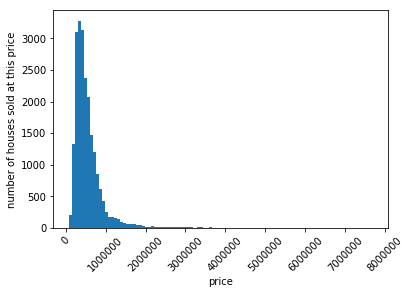

In [7]:
plt.hist(houses['price'], bins = 100)
plt.xticks(rotation=45)
plt.xlabel('price')
plt.ylabel('number of houses sold at this price')
plt.show()

Looking at sale price by location, some areas certainly look to have higher sales prices than others.

(To get the color ramp to be meaningful, I dropped all datapoints with sale prices above $\$$2 million, just for this plot. Other possible ways to get a meaningful color ramp could include binning by quartilesor using a log scale)

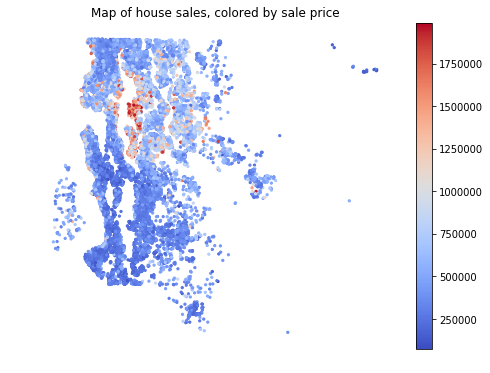

In [8]:
houses_clipped = houses[houses['price']<2000000]
plt.figure(figsize=(8,6))
plt.scatter(houses_clipped['long'], houses_clipped['lat'], c=houses_clipped['price'], s=5, cmap='coolwarm')
plt.colorbar()
plt.title('Map of house sales, colored by sale price')
plt.axis('off')
plt.show()

## How do features relate to price?

Looks like price increases with increasing bedrooms, bathrooms, square feet of living space, and lot size. Year built doesn’t look like it has much of a relationship with price. Lot size also looks like it may have two separate populations with different correlation coefficients (perhaps condos and houses?).

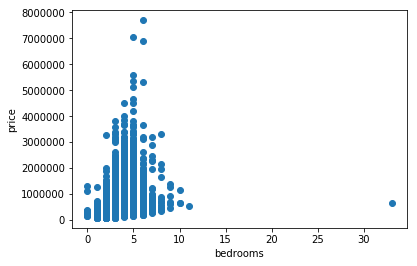

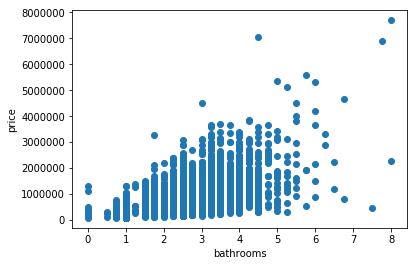

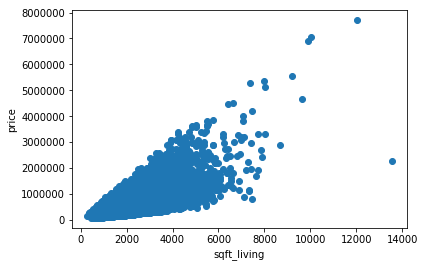

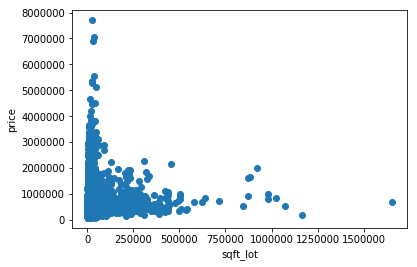

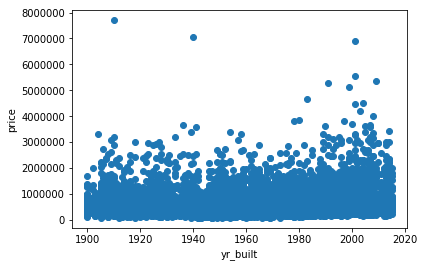

In [9]:
for feature in ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'yr_built']:
    #plt.figure(figsize=(5,3))
    plt.scatter(houses[feature], houses['price'])
    plt.xlabel(feature)
    plt.ylabel('price')
    plt.show()

Being by the waterfront increases sale price, as does grade (not totally sure what grade represents though). Views also increase price slightly. Condition and number of floors don’t seem to have much of an impact on price.

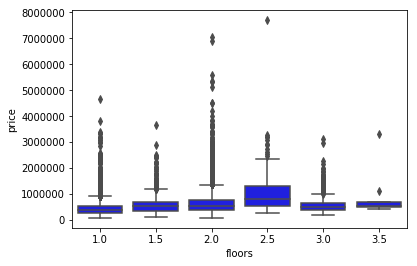

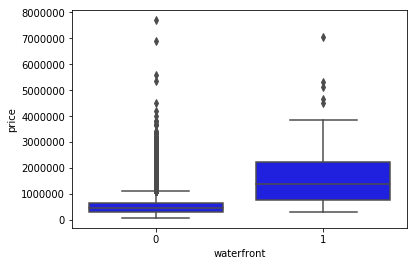

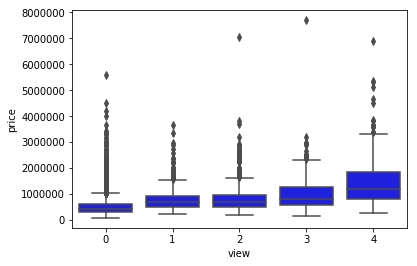

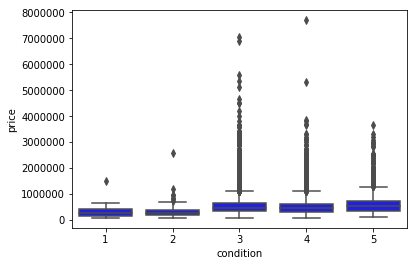

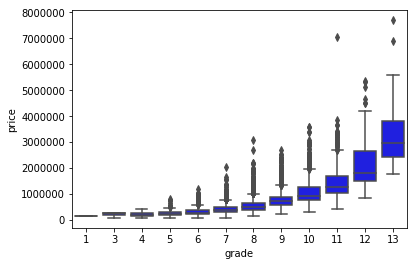

In [10]:
for feature in ['floors', 'waterfront', 'view', 'condition', 'grade']:
    sns.boxplot(x=feature, y='price', color= 'b', data=houses)
    plt.show()

Looking at all the features, are any of them highly correlated? There does seem to be some correlation between bedrooms, bathrooms, and square feet of living space, but nothing so strong that we shouldn't include all these features (one feature is not completely predictive of another)

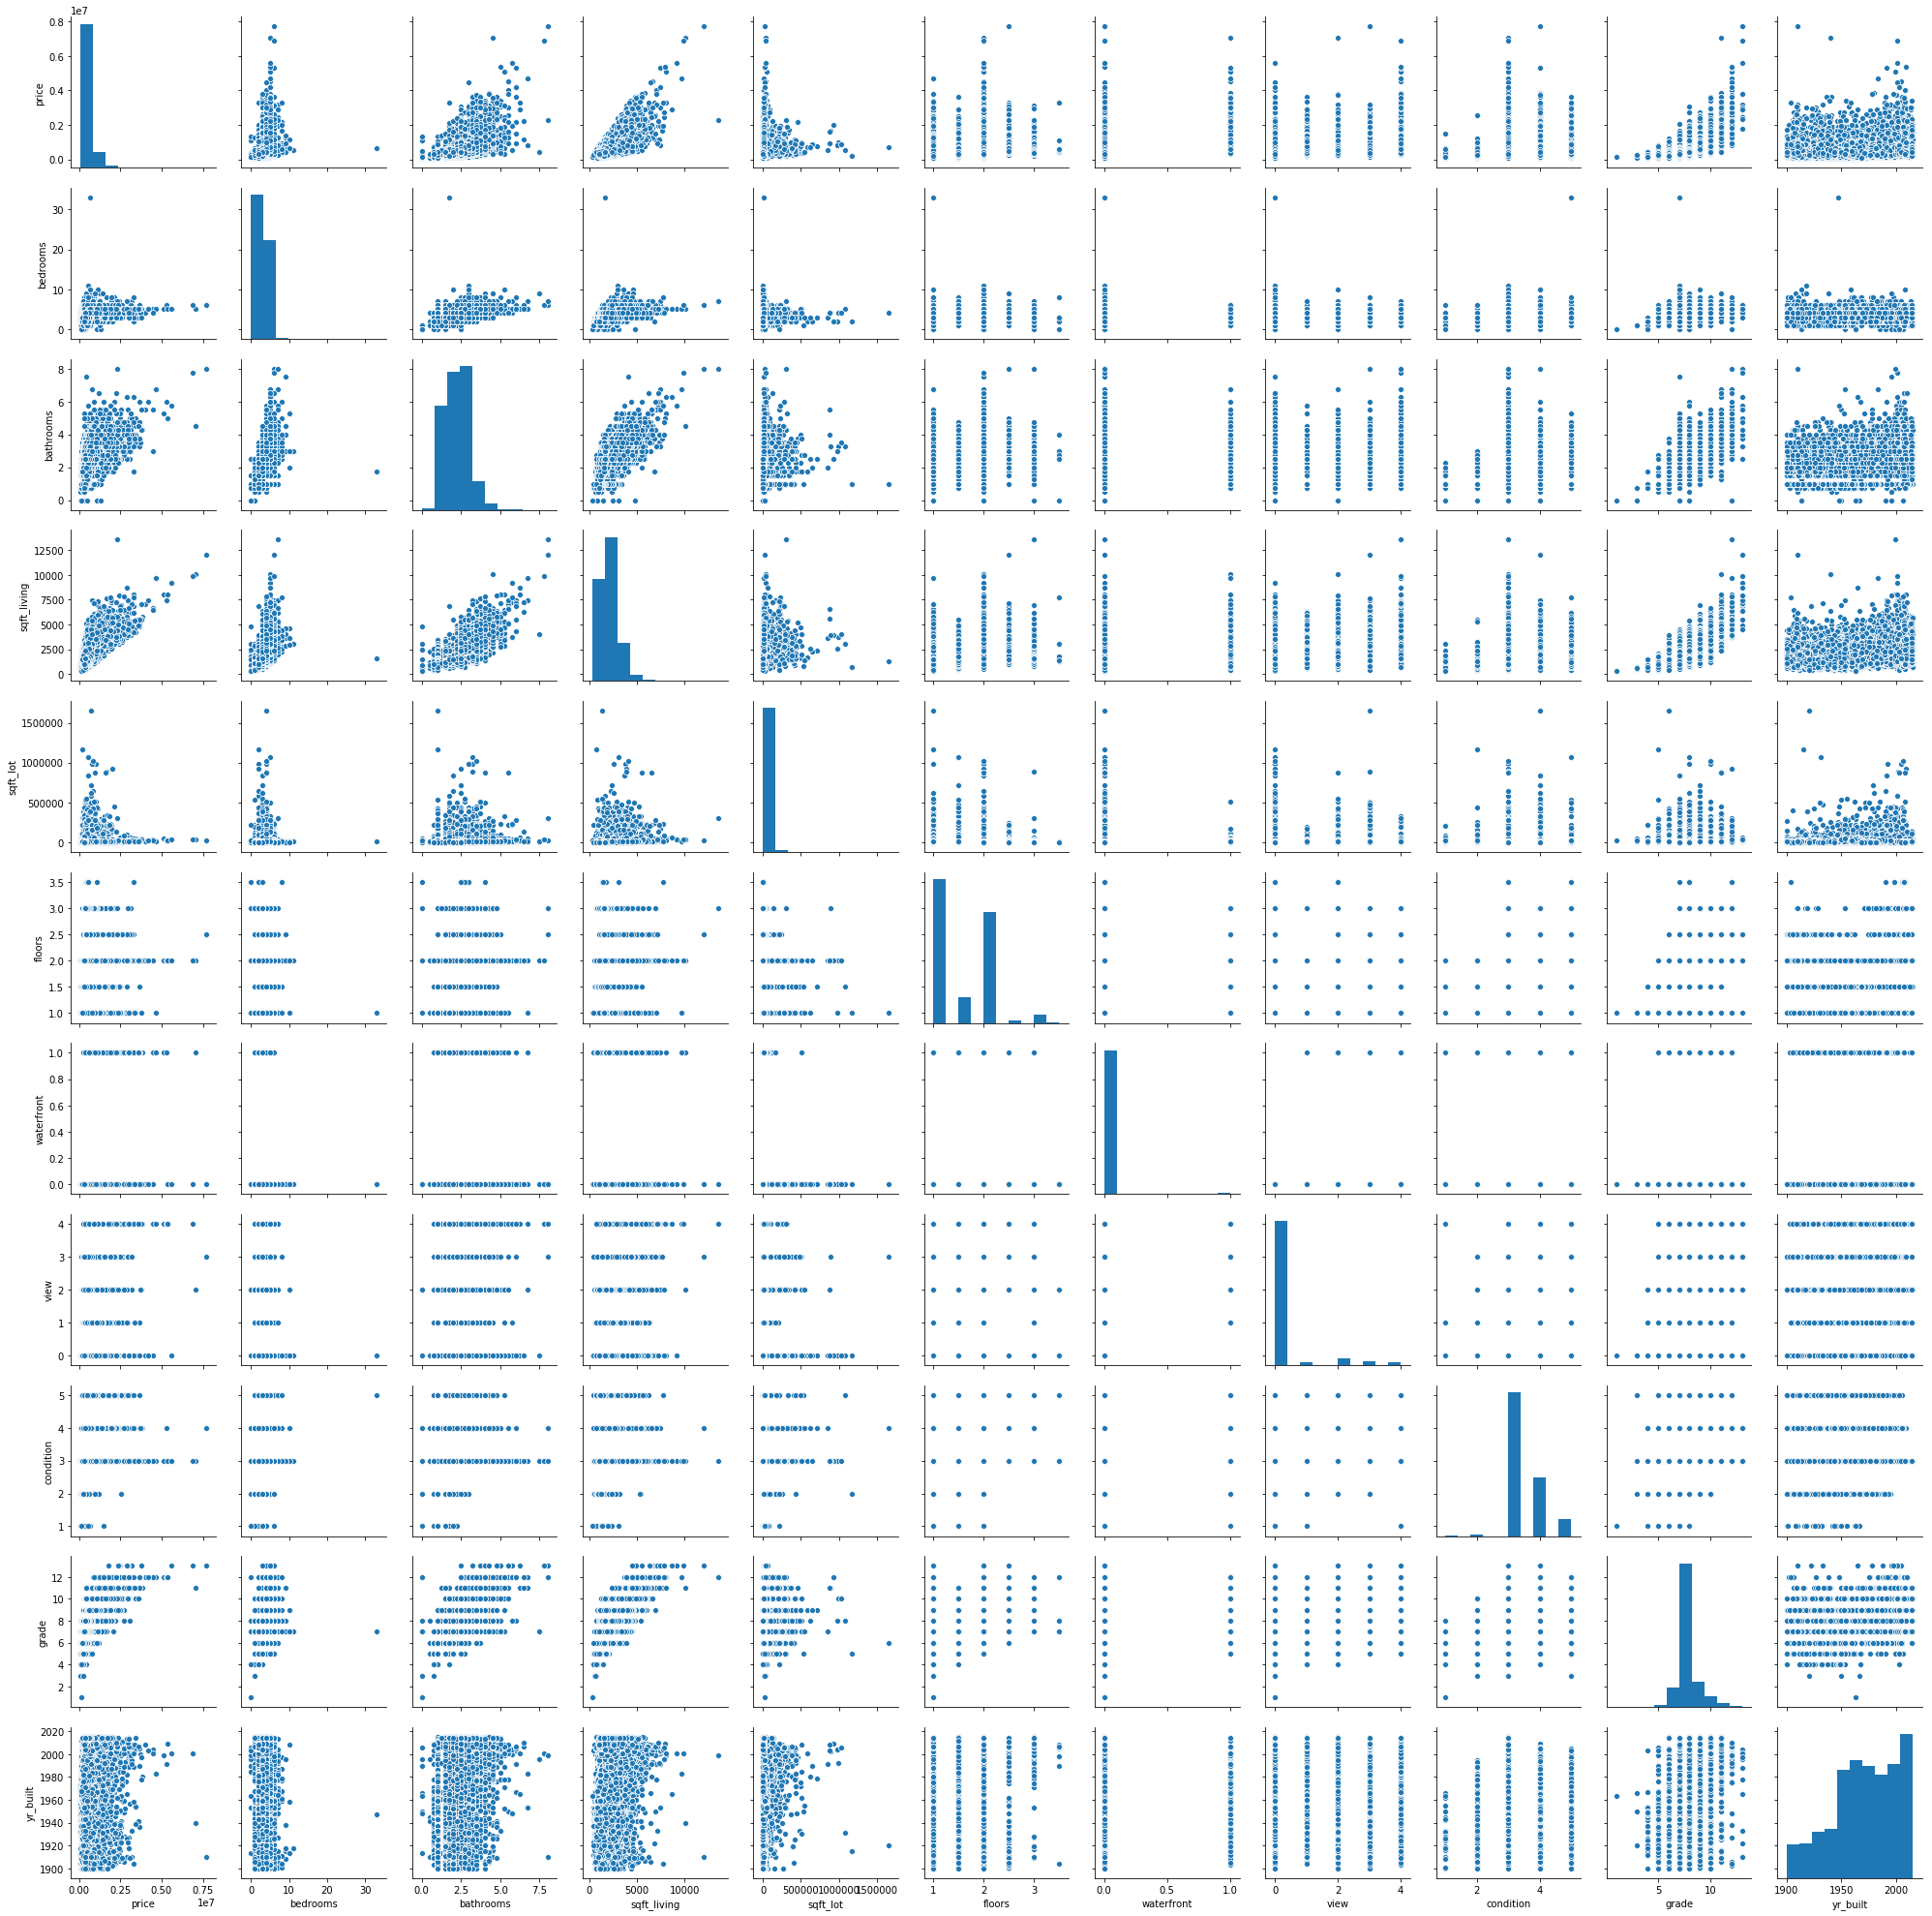

In [11]:
sns.pairplot(houses[['price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'yr_built']])

### Creating a test set
Time series split - we are trying to predict house prices in the future. This means that our test set should be only the most recent sales. (so the test set is in the future relative to the training data). I defined the test set as houses sold on or after March 1, 2015.

When cross validating different models, use a time-series-split cross validator.

In [12]:
houses_test = houses[houses['date_sold']>='2015-03-01']
houses_train = houses[houses['date_sold']<'2015-03-01']
houses_train = houses_train.sort_values('date_num')
X_test = houses_test.drop(['price', 'date_sold'], axis=1)
y_test = houses_test['price']
X_train = houses_train.drop(['price', 'date_sold'], axis=1)
y_train = houses_train['price']

### What’s the baseline we’re trying to beat?

The median price for houses in this area in our training set is $\$$449,000. If we predict every house in the test set to be this price, the mean absolute error is $226,622 - so that’s the error to beat!

Note that I’m using median instead of mean as the baseline predictor because of the distribution of the data. As we saw earlier, there is a long tail on the upper end of the price distribution, which skews the mean high. The median is more representative of the “center” of this dataset.

In [13]:
(y_test - y_train.mean()).abs().mean()

234100.74605072357

In [14]:
(y_test - y_train.median()).abs().mean()

226622.19360269362

### K-nearest neighbors, or the “comps” approach
For decades, real estate pricing has been based on “comps” - what did similar houses in the same area sell for? This has a lot in common with k-nearest neighbors, where we predict prices based on the most similar data points. So let’s see how that works!

For KNN, we need to scale the data to prevent features with large values from dominating the prediction.

In [15]:
#scale features data
scaler = StandardScaler()
scaler.fit(X_train.astype(float))
X = scaler.transform(X_train.astype(float))

#time series split
tscv = TimeSeriesSplit(n_splits=3)

knn_model = KNeighborsRegressor(n_neighbors = 10, weights= 'distance')
cross_val_score(knn_model, X, y_train, cv=tscv.split(X), scoring='neg_mean_absolute_error').astype(object)

array([-94446.99587965722, -94038.78228961205, -99237.05680877951],
      dtype=object)

In [16]:
np.array([-92146.66742486521, -93534.06871911885, -97753.20958064811]).mean()

-94477.98190821073

Looks better than the baseline at least!

And a quick look at the test set:

In [17]:
knn_model.fit(X, y_train)
(knn_model.predict(scaler.transform(X_test.astype(float))) - y_test).abs().mean()

107365.06144467462

### Some fancier models
So KNN more or less the existing practice, but that might just be because it’s easy for a human to do. What if we try some other models - will they perform better?

#### Random Forest

In [18]:
rf_model = RandomForestRegressor(n_estimators=50)
cross_val_score(rf_model, X_train, y_train, cv=tscv.split(X_train), scoring='neg_mean_absolute_error')

array([-73743.3855516 , -72278.18725504, -73460.09033926])

In [19]:
np.array([-72909.22645789, -71544.47502254, -72099.95094662]).mean()

-72184.55080901667

#### Gradient Boosting

In [20]:
gb_model = GradientBoostingRegressor(n_estimators=100)
cross_val_score(gb_model, X_train, y_train, cv=tscv.split(X_train), scoring='neg_mean_absolute_error')

array([-75320.16124487, -76411.84819816, -80660.31278034])

In [21]:
np.array([-73260.20904179, -75661.62179848, -77265.55079167]).mean()

-75395.79387731334

So both of these perform better than the KNN approach!

Do different models perform better in different regions of the price range? Not really. Looks like the tree models are just overall a little better than KNN.

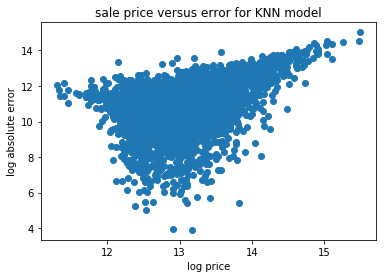

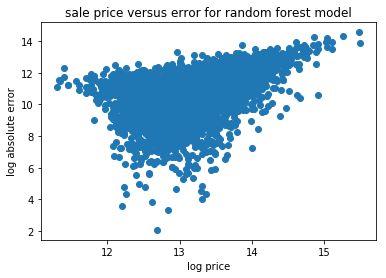

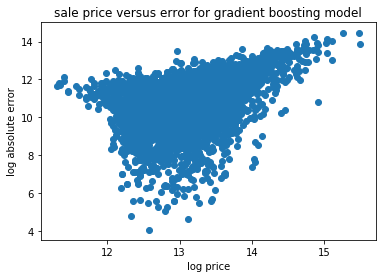

In [22]:
knn_model.fit(X, y_train)
plt.scatter(np.log(y_test), np.log((knn_model.predict(scaler.transform(X_test.astype(float))) - y_test).abs()))
plt.xlabel('log price')
plt.ylabel('log absolute error')
plt.title('sale price versus error for KNN model')
plt.show()

rf_model.fit(X_train, y_train)
plt.scatter(np.log(y_test), np.log((rf_model.predict(X_test) - y_test).abs()))
plt.xlabel('log price')
plt.ylabel('log absolute error')
plt.title('sale price versus error for random forest model')
plt.show()

gb_model.fit(X_train, y_train)
plt.scatter(np.log(y_test), np.log((gb_model.predict(X_test) - y_test).abs()))
plt.xlabel('log price')
plt.ylabel('log absolute error')
plt.title('sale price versus error for gradient boosting model')
plt.show()

## But is this good enough?
Our mean error on the best performing model, random forest, was still over $\$$72,000. That's not great when you think in real-world terms - on a house that costs $450,000 (the median price of this dataset), that's a big error! 

However, it does look like the error increases with increasing price, and the error is smaller for lower-priced houses.

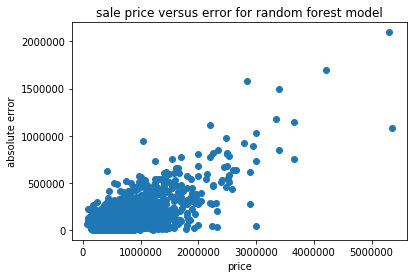

In [23]:
plt.scatter((y_test), (rf_model.predict(X_test) - y_test).abs())
plt.xlabel('price')
plt.ylabel('absolute error')
plt.title('sale price versus error for random forest model')
plt.show()

So since we don't have very many expensive houses, maybe this model just doesn't have enough information to predict on those outliers (and the multi-million dollar market may also have different behavior than the rest of the housing market). So what if we only try to create a model that predicts prices for houses less than $\$$1 million?

In [24]:
houses_clipped = houses[houses['price']<1000000]
houses_test_clipped = houses_clipped[houses_clipped['date_sold']>='2015-03-01']
houses_train_clipped = houses_clipped[houses_clipped['date_sold']<'2015-03-01']
houses_train_clipped = houses_train_clipped.sort_values('date_num')
X_test_clipped = houses_test_clipped.drop(['price', 'date_sold'], axis=1)
y_test_clipped = houses_test_clipped['price']
X_train_clipped = houses_train_clipped.drop(['price', 'date_sold'], axis=1)
y_train_clipped = houses_train_clipped['price']

In [25]:
#scale features data
scaler = StandardScaler()
scaler.fit(X_train_clipped.astype(float))
X_clipped = scaler.transform(X_train_clipped.astype(float))

#time series split
tscv = TimeSeriesSplit(n_splits=3)

knn_model = KNeighborsRegressor(n_neighbors = 10, weights= 'distance')
cross_val_score(knn_model, X_clipped, y_train_clipped, cv=tscv.split(X_clipped), scoring='neg_mean_absolute_error').mean()

-71311.35175587538

In [26]:
rf_model = RandomForestRegressor(n_estimators=50)
cross_val_score(rf_model, X_train_clipped, y_train_clipped, cv=tscv.split(X_train_clipped), 
                scoring='neg_mean_absolute_error').mean()

-53868.91386811385

So that improved things a bit, but probably still not enough for a real-world application.

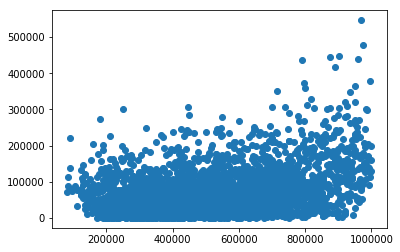

In [27]:
rf_model.fit(X_train_clipped, y_train_clipped)
plt.scatter((y_test_clipped), (rf_model.predict(X_test_clipped) - y_test_clipped).abs())

## Next steps

Try using a reduced set of features. As we saw in the beginning, some of the features don’t seem to have much correlation with price, and may be adding noise to the models.

Random Forest and Gradient Boosting performed best, and were pretty close to each other. Grid search on Random Forest and Gradient Boosting to find the best parameters and see if one comes out ahead.

Try linear regression (spoiler - this was tried by others and didn't work very well. Some of the features are not linearly related to the price)


In [28]:
rf_model.fit(X_train, y_train)
X_train.columns[rf_model.feature_importances_.argsort()]

Index(['floors', 'yr_renovated', 'condition', 'bedrooms', 'sqft_basement',
       'bathrooms', 'date_num', 'view', 'sqft_lot', 'sqft_above', 'yr_built',
       'waterfront', 'long', 'lat', 'sqft_living', 'grade'],
      dtype='object')

In [31]:
rfpimp.importances(rf_model, X_test, y_test)

,Importance
Feature,
lat,0.408524
sqft_living,0.330266
grade,0.259264
long,0.134997
yr_built,0.030430
waterfront,0.022765
sqft_lot,0.016994
sqft_above,0.012445
view,0.012265


In [32]:
gb_model.fit(X_train, y_train)
X_train.columns[gb_model.feature_importances_.argsort()]

Index(['floors', 'bedrooms', 'date_num', 'yr_renovated', 'bathrooms',
       'condition', 'sqft_basement', 'sqft_lot', 'sqft_above', 'view',
       'yr_built', 'waterfront', 'long', 'lat', 'grade', 'sqft_living'],
      dtype='object')